In [91]:
import numpy as np
import sys
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

caffe_root='/usr/local/google/home/zyan/proj/caffe_private_recurrent_2d/'
sys.path.insert(0, caffe_root + 'python')
import caffe
import os
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import skimage.transform
import time

In [111]:
# Set the right path to your model definition file, pretrained model weights,
# and the image you would like to classify.
google_caffe_root = '/usr/local/google/home/zyan/proj/caffe/'
# layer_dir=google_caffe_root+'google_extra/examples/stanford_background/grid_lstm_3d_1_lay/'
layer_dir=google_caffe_root+'google_extra/examples/stanford_background/renet_3_lay/'

model_name = 'renet_3_lay_MP_nolbw_nopeep_lr5e-2'
iter_num = 19000
MODEL_FILE = google_caffe_root+\
'google_extra/examples/stanford_background/renet_3_lay_MP_nolbw_nopeep_deploy.prototxt'
PRETRAINED =layer_dir +'%s_iter_%d.caffemodel'%(model_name, iter_num)

net_input_multiple = [3,3]
label_names=['0:unknown','1:sky','2:tree','3:road','4:grass','5:water','6:building','7:mountain','8:foreground']
data_mean=np.array([104,117,123])
num_label=9

print 'MODEL_FILE: %s' % MODEL_FILE
print 'PRETRAINED : %s' % PRETRAINED

caffe.set_mode_gpu()
net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)

MODEL_FILE: /usr/local/google/home/zyan/proj/caffe/google_extra/examples/stanford_background/renet_3_lay_MP_nolbw_nopeep_deploy.prototxt
PRETRAINED : /usr/local/google/home/zyan/proj/caffe/google_extra/examples/stanford_background/renet_3_lay/renet_3_lay_MP_nolbw_nopeep_lr5e-2_iter_19000.caffemodel


In [109]:
[ (layer, net.blobs[layer].data.shape) for layer in net.blobs]

[('data', (1, 3, 240, 321)),
 ('renet_lstm_1_vertical', (1, 80, 80, 107)),
 ('renet_lstm_1_horizontal', (1, 80, 80, 107)),
 ('conv1', (1, 80, 80, 107)),
 ('renet_lstm_2_vertical', (1, 120, 80, 107)),
 ('renet_lstm_2_horizontal', (1, 120, 80, 107)),
 ('conv2', (1, 120, 80, 107)),
 ('renet_lstm_3_vertical', (1, 120, 80, 107)),
 ('renet_lstm_3_horizontal', (1, 120, 80, 107)),
 ('conv3', (1, 9, 80, 107)),
 ('conv3_full_res', (1, 9, 240, 321)),
 ('prob', (1, 9, 240, 321))]

In [82]:
[ (k, v[0].data.shape) for k,v in net.params.items()]

[('renet_lstm_1_vertical', (20, 47)),
 ('renet_lstm_1_horizontal', (20, 60)),
 ('conv1', (40, 40, 1, 1)),
 ('renet_lstm_2_vertical', (30, 70)),
 ('renet_lstm_2_horizontal', (30, 90)),
 ('conv2', (60, 60, 1, 1)),
 ('renet_lstm_3_vertical', (30, 90)),
 ('renet_lstm_3_horizontal', (30, 90)),
 ('conv3', (9, 60, 1, 1))]

In [105]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)
    plt.axis('off')
    
def vis_renet_lstm(lstm_params):
    filters=lstm_params[0].data
    filters=filters[:,:27]
    n_filters=filters.shape[0]
    filters=filters.reshape((n_filters, 3, 3, 3))
    print filters.shape
    vis_square(filters)    
    
def show_label_map(label_map):
    ''' to extend the color map to the full range [0,8]
        assign label 0 to a pixel in the corner
        assign label 8 to a pixel in the corner
    '''
    label_map_copy = np.copy(label_map)
    label_map_copy[0,0]=0
    label_map_copy[-1,-1]=num_label-1
    plt.imshow(label_map_copy, cmap='jet')
    plt.axis('off')    
#     cbar=plt.colorbar(ticks=np.arange(num_label))
#     cbar.ax.set_yticklabels(label_names)

def read_label_file(label_file_path, label_offset = -1):
    with open(label_file_path) as f:
        lines = f.readlines()
        height=len(lines)
        width = len(lines[0].split(' '))
        label_map=np.zeros((height,width),dtype=np.int32)
        for y in range(height):
            row_labels = lines[y].split(' ')
            for x in range(width):
                label_map[y,x]=int(row_labels[x])-label_offset
        return label_map
    
''' pad image so that its height and width are multiples of the given scalar
'''
def pad_image(image, image_multiple):
    out_height = np.ceil(float(image.shape[0]) / float(image_multiple[0])) * image_multiple[0]
    out_width = np.ceil(float(image.shape[1]) / float(image_multiple[1])) * image_multiple[1]
    out_img = np.zeros((out_height, out_width, image.shape[2]))
    out_img[:image.shape[0],:image.shape[1],:]=image
    if out_height > image.shape[0]:
        bottom_border = image[image.shape[0]-1,:,:]
        out_img[image.shape[0]:, :image.shape[1], :] = bottom_border[np.newaxis,:,:]
    if out_width > image.shape[1]:
        right_border = image[:,image.shape[1] - 1,:]
        out_img[:image.shape[0],image.shape[1]:,:]=right_border[:,np.newaxis,:]
    if out_height > image.shape[0] and out_width > image.shape[1]:
        right_bottom_corner = image[-1,-1,:]
        out_img[image.shape[0]:, image.shape[1]:, :] = right_bottom_corner[np.newaxis,np.newaxis,:]

    return out_img

def process_label_map(label_map, num_label):
    ''' For visualization purpose, extend the color map to the full range [0,8]
        assign label 0 to a pixel in the corner
        assign label 8 to a pixel in the corner
    '''    
    label_map[0,0]=0
    label_map[-1,-1]=num_label-1
    return label_map

In [6]:
img_dir='/usr/local/google/home/zyan/data/stanford_background/images/'
label_dir='/usr/local/google/home/zyan/data/stanford_background/labels/'
gt_seg_dir='/usr/local/google/home/zyan/data/stanford_background/segment_vis/'

test_list=caffe_root+'examples/stanford_background/test_0.txt'
test_img_names=[]
with open(test_list) as f:
    for line in f.readlines():
        test_img_names += [line[:-1]]

In [7]:
'''data transform parameters'''
input_scale = 0.0078125

test image name 6000336
test_img_name shape  (240, 320, 3)


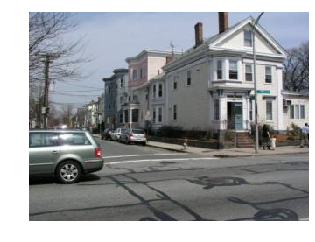

In [74]:
'''case studies'''
test_img_name = test_img_names[19]
print 'test image name %s' % test_img_name
test_img = caffe.io.load_image(img_dir+test_img_name+'.jpg')
print 'test_img_name shape ', test_img.shape
plt.axis('off')
plt.imshow(test_img)

In [75]:
padded_img = pad_image(test_img,net_input_multiple)
print 'padded_img shape', padded_img.shape

padded_img shape (240, 321, 3)


In [76]:
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': [1, 3, padded_img.shape[0], padded_img.shape[1]]})
# transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', data_mean) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
transformer.set_input_scale('data', input_scale)

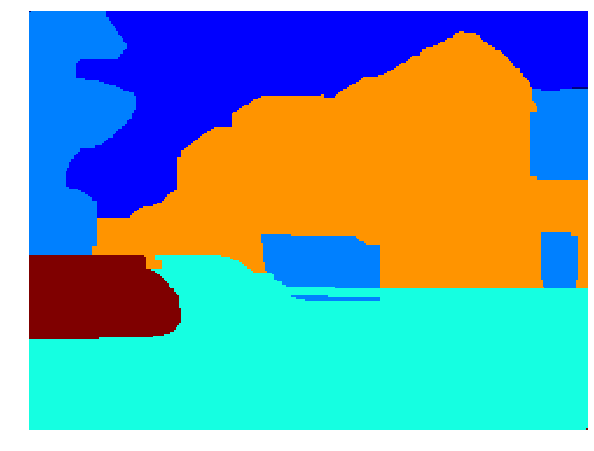

In [106]:
label_map = read_label_file(label_dir + test_img_name + '.regions.txt')
show_label_map(label_map)

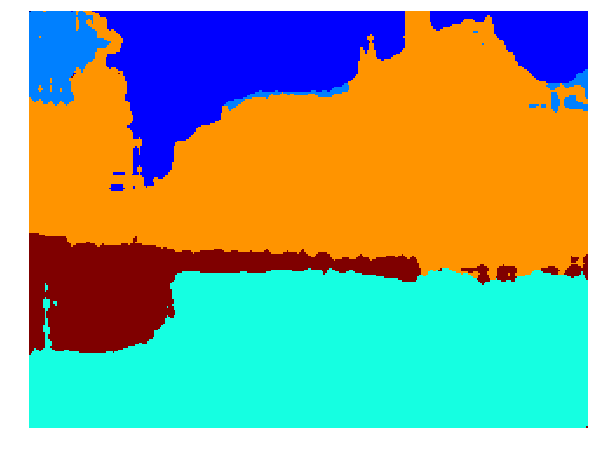

In [107]:
net.blobs['data'].data[...] = transformer.preprocess('data', padded_img)
out = net.forward()
pred_label_map=np.argmax(net.blobs['prob'].data[0,:,:,:],axis=0)
show_label_map(pred_label_map)

(40, 80, 107)


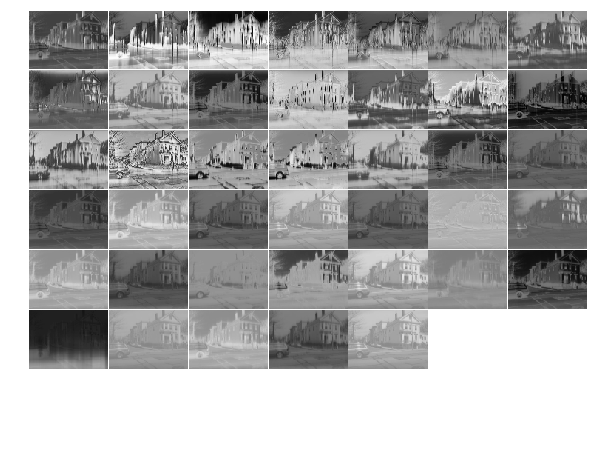

In [93]:
ftr_map=net.blobs['renet_lstm_1_vertical'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)

(40, 80, 107)


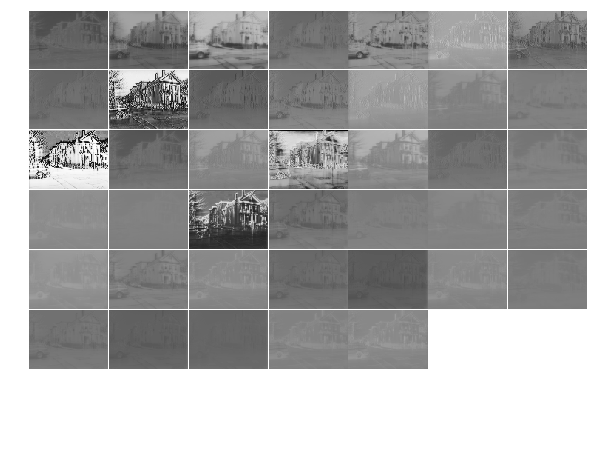

In [94]:
ftr_map=net.blobs['renet_lstm_1_horizontal'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)

(40, 80, 107)


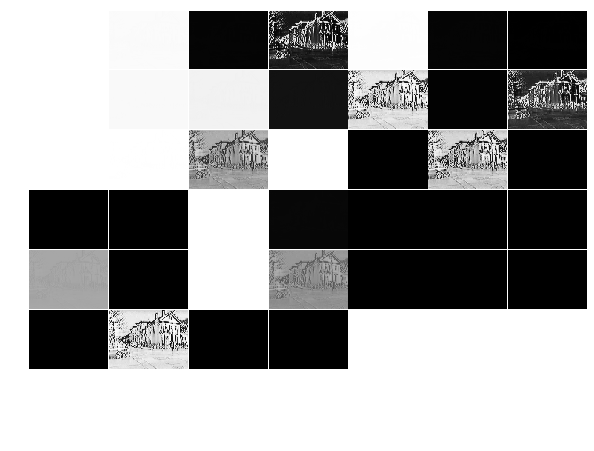

In [95]:
ftr_map=net.blobs['conv1'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)

(60, 80, 107)


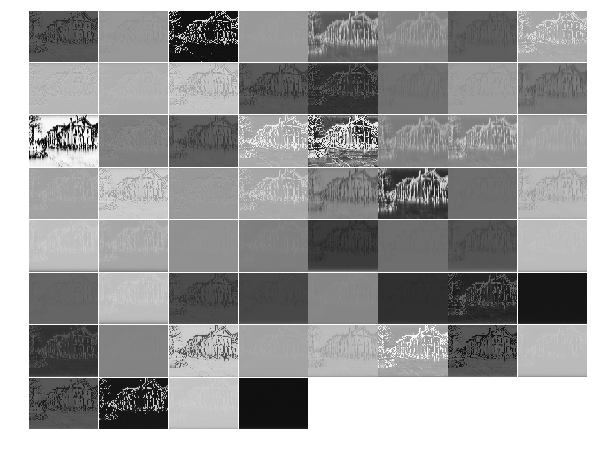

In [96]:
ftr_map=net.blobs['renet_lstm_2_vertical'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)

(60, 80, 107)


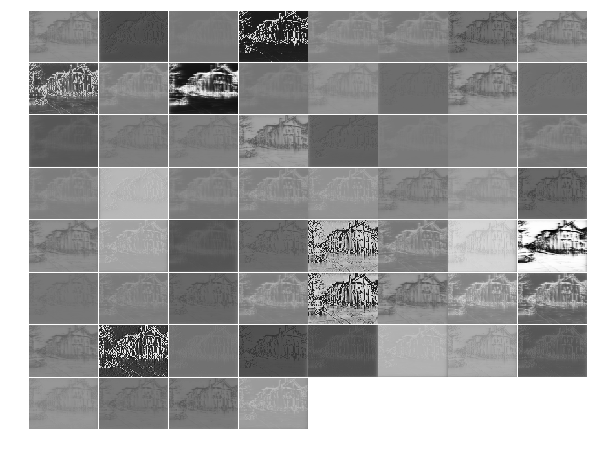

In [97]:
ftr_map=net.blobs['renet_lstm_2_horizontal'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)

(60, 80, 107)


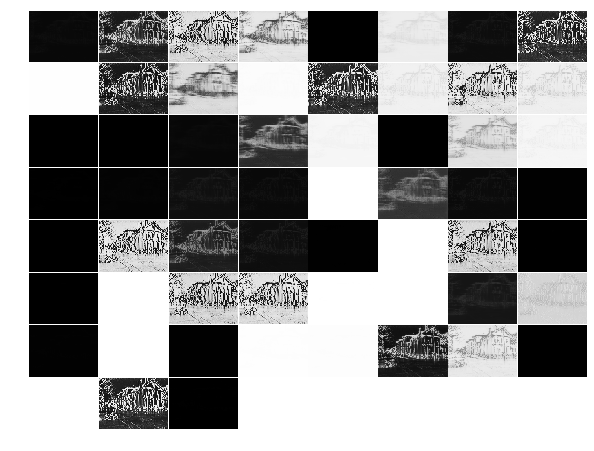

In [98]:
ftr_map=net.blobs['conv2'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)

(60, 80, 107)


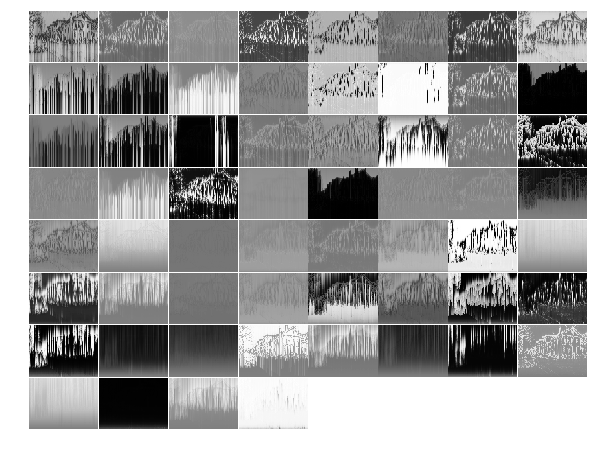

In [99]:
ftr_map=net.blobs['renet_lstm_3_vertical'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)

(60, 80, 107)


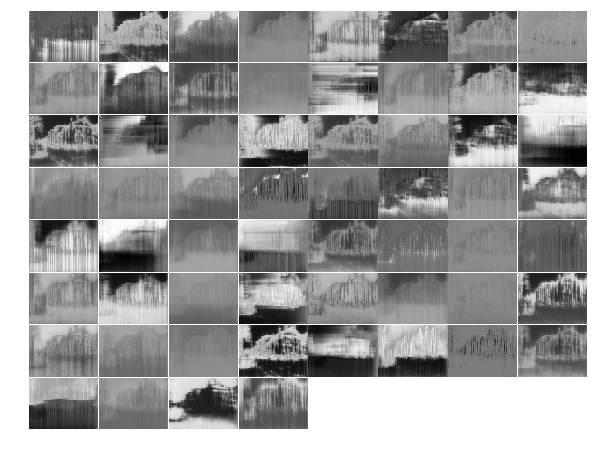

In [100]:
ftr_map=net.blobs['renet_lstm_3_horizontal'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)

(9, 80, 107)


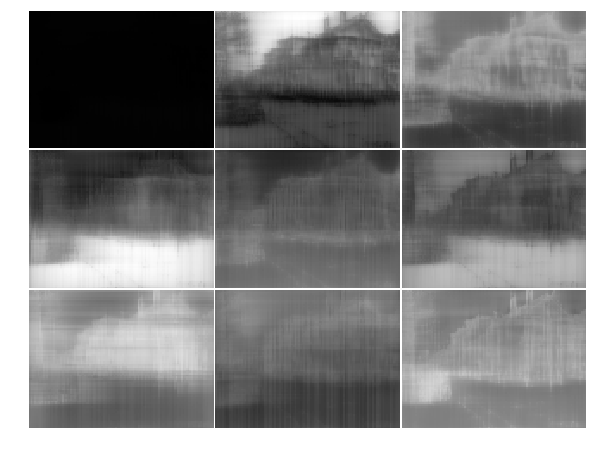

In [101]:
ftr_map=net.blobs['conv3'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)

(9, 240, 321)


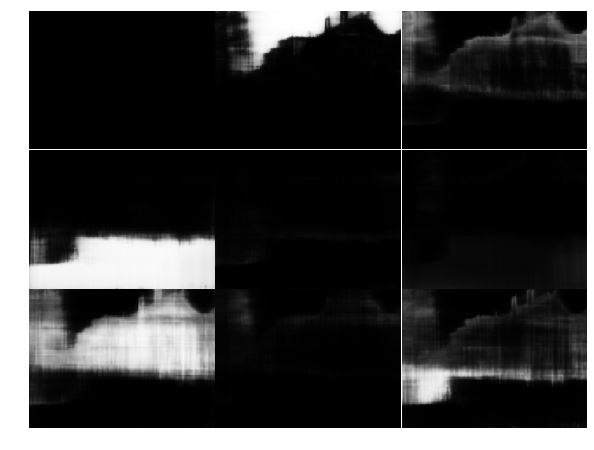

In [102]:
ftr_map=net.blobs['prob'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)

In [112]:
'''evaluate test set'''

pred_label_image_save_dir = layer_dir + model_name + '_prediction/'
if not os.path.exists(pred_label_image_save_dir):
    os.mkdir(pred_label_image_save_dir)


class_agnostic_pix_correct = 0.0
class_agnostic_pix_total = 0.0
class_pix_correct = np.zeros((num_label))
class_pix_total = np.zeros((num_label))

st_time = time.time()

for i,test_img_name in enumerate(test_img_names):
# for i in range(2):
    if i % 20 == 0:
        print 'process %d out of %d images' % (i, len(test_img_names))
        ep_time = time.time() - st_time
        st_time = time.time()
        print 'elapsed time %4.2f' % ep_time
    test_img_name = test_img_names[i]
#     print 'test image name %s' % test_img_name
    test_img = caffe.io.load_image(img_dir+test_img_name+'.jpg')
#     print 'test_img_name shape ', test_img.shape
    in_height, in_width = test_img.shape[0], test_img.shape[1]
    
    padded_img = pad_image(test_img,net_input_multiple)
    padded_height, padded_width = padded_img.shape[0], padded_img.shape[1]
    
    transformer = caffe.io.Transformer({'data': [1, 3, padded_img.shape[0], padded_img.shape[1]]})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', data_mean) # mean pixel
    transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
    transformer.set_input_scale('data', input_scale)  
    
    net.blobs['data'].reshape(1, 3, padded_height, padded_width)
    net.blobs['data'].data[...] = transformer.preprocess('data', padded_img)
    out = net.forward()
    
    '''  ground truth label '''
    gt_label = read_label_file(label_dir + test_img_name + '.regions.txt')
    ''' predicted label '''
    pred_label=np.argmax(net.blobs['prob'].data[0,:,:,:],axis=0)
    pred_label = pred_label[:in_height, :in_width]
    
    assert gt_label.shape == pred_label.shape
    
    pred_correct = pred_label == gt_label
    lc_class_agnostic_pix_correct = np.sum(pred_correct)
    lc_class_agnostic_pix_total = in_height * in_width
    class_agnostic_pix_correct += lc_class_agnostic_pix_correct
    class_agnostic_pix_total += lc_class_agnostic_pix_total
    lc_pixel_accu = (float(lc_class_agnostic_pix_correct) / float(lc_class_agnostic_pix_total))
    
#     print 'lc_class_agnostic_pix_correct ',lc_class_agnostic_pix_correct
#     print 'lc_class_agnostic_pix_total ',lc_class_agnostic_pix_total
#     print 'pixel accuracy %f ' % (lc_pixel_accu)
    
    for l in range(num_label):
        idx = np.nonzero(gt_label == l)
        class_pix_correct[l] += np.sum(pred_correct[idx[0], idx[1]])
        class_pix_total[l]+= len(idx[0])
#         if len(idx[0]) > 0:
#             print 'class %d accuracy %f' % (l, float(np.sum(pred_correct[idx[0], idx[1]]))/len(idx[0]))
                            
                            
    gt_label=process_label_map(gt_label, num_label)
    pred_label=process_label_map(pred_label, num_label)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[20, 10])
    
    im1 = ax1.imshow(test_img)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)    
    ax1.set_title('input')
    
    im2 = ax2.imshow(pred_label, cmap='jet')
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.set_title('prediction, pix accuracy: %4.2f' % (lc_pixel_accu*100))
    
    im3 = ax3.imshow(gt_label, cmap='jet')
    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax3.set_title('groundtruth')
     
    axins = inset_axes(ax3,
                       width="5%", # width = 10% of parent_bbox width
                       height="100%", # height : 50%
                       loc=3,
                       bbox_to_anchor=(1.05, 0., 1, 1),
                       bbox_transform=ax3.transAxes,
                       borderpad=0)

    cbar=plt.colorbar(im3, ticks=np.arange(num_label), cax=axins)
    cbar.ax.set_yticklabels(label_names)   

    plt.savefig(pred_label_image_save_dir+test_img_name+'.jpg', bbox_inches='tight')
    plt.close()

assert class_agnostic_pix_total == np.sum(class_pix_total)

pixel_accu = class_agnostic_pix_correct/class_agnostic_pix_total
class_accu = class_pix_correct / class_pix_total
print 'pixel accuracy %4.2f' % (pixel_accu*100.0)
print 'class accuracy %4.2f' % (np.mean(class_accu[1:])*100.0)

process 0 out of 143 images
elapsed time 0.00
process 20 out of 143 images
elapsed time 10.69
process 40 out of 143 images
elapsed time 12.05
process 60 out of 143 images
elapsed time 11.37
process 80 out of 143 images
elapsed time 11.13
process 100 out of 143 images
elapsed time 11.20
process 120 out of 143 images
elapsed time 11.40
process 140 out of 143 images
elapsed time 11.69
pixel accuracy 79.35
class accuracy 69.36
